# SVD (Singular Value Decomposition)

$\huge R = P_{mk}S_{kk}Q^T_{kn}$

- La matriz S es diagonal. Sus valores estan ordenados de mayor a menor. 
- Cada valor de la diagonal de S indica que tan importante es ese feature
- Puedo quedarme con los primeros y aproximar la matriz R
- Tengo que definir las peliculas no calificadas con algun valor 
- Tanto P como Q son ortogonales
- Si R es una matriz real, la decomposición existe
- Elegimos el K y nos garantiza que el la mejor aproximación de rango K (Rank K best aproximation) Trunkated SVD

In [1]:
from scipy.sparse.linalg import svds
import pandas as pd
import numpy as np

In [2]:
def SVD(users_items_train_matrix, k = 20):
    #get SVD components from train matrix. Choose k.
    u, s, vt = svds(users_items_train_matrix, k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    return X_pred

In [3]:
def rmse(R, R_estimated):
    # No es conmutativa! Primero va ground truth, normalmente R_test
    # Segundo van las predicciones
    # Es necesario el orden para que el nonzero sea del ground truth
    nonzeros = R.nonzero()
    prediction = R_estimated[nonzeros].flatten()
    ground_truth = R[nonzeros].flatten()
    return np.sqrt(((prediction - ground_truth)**2).sum()/ground_truth.shape[0])

In [4]:
header = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)
n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]

In [5]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2)

In [6]:
n_split = 20000
train_data = df[n_split:]
test_data = df[:n_split]
len(train_data), len(test_data)

(80000, 20000)

In [28]:
test_data.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

# Aplico SVD directamente

In [25]:
train_data_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [10]:
test_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
SVD_Predictions = SVD(train_data_matrix, k=200)

In [32]:
print('Training:',rmse(train_data_matrix, SVD_Predictions))
print('Testing:',rmse(test_data_matrix, SVD_Predictions))

Training: 1.0590301482181055
Testing: 3.541300715956298


In [46]:
mse_train = []
mse_test = []
ks = [2, 4, 5, 7, 10, 12, 15, 20, 50]
for k in ks:
    SVD_Predictions = SVD(train_data_matrix, k=k)
    mse_train.append(rmse(train_data_matrix, SVD_Predictions))
    mse_test.append(rmse(test_data_matrix, SVD_Predictions))

In [47]:
from matplotlib import pyplot as plt

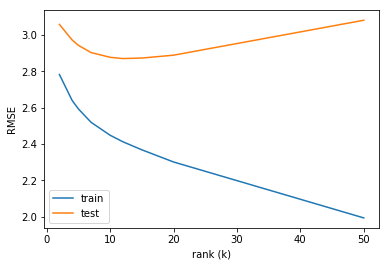

In [49]:
plt.plot(ks, mse_train, label='train')
plt.plot(ks, mse_test, label='test')
plt.xlabel('rank (k)')
plt.ylabel('RMSE')
plt.legend()

In [57]:
SVD_Predictions = SVD(train_data_matrix, k=12)
print(rmse(train_data_matrix, SVD_Predictions))
print(rmse(test_data_matrix, SVD_Predictions))

2.4126220915790637
2.8694009323922436


# Que pasa si predigo con la media:

In [13]:
mu = train_data_matrix[train_data_matrix.nonzero()].mean()
print(mu)

3.52835


In [14]:
print('Training:',rmse(train_data_matrix, mu*np.ones(train_data_matrix.shape)))
print('Testing:',rmse(test_data_matrix, mu*np.ones(test_data_matrix.shape)))

Training: 1.1185576773237935
Testing: 1.1536759477860323


# Agrego la media al SVD

In [58]:
train_data_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [61]:
# Resto la media solo a los distinto de cero
R_train_norm = (train_data_matrix - mu)*(train_data_matrix>0) 

In [62]:
R_train_norm

array([[ 1.47165, -0.52835,  0.47165, ..., -0.     , -0.     , -0.     ],
       [ 0.47165, -0.     , -0.     , ..., -0.     , -0.     , -0.     ],
       [-0.     , -0.     , -0.     , ..., -0.     , -0.     , -0.     ],
       ...,
       [ 1.47165, -0.     , -0.     , ..., -0.     , -0.     , -0.     ],
       [-0.     , -0.     , -0.     , ..., -0.     , -0.     , -0.     ],
       [-0.     ,  1.47165, -0.     , ..., -0.     , -0.     , -0.     ]])

In [80]:
SVD_Predictions_norm = SVD(R_train_norm, k=11) + mu

In [81]:
print('Training:',rmse(train_data_matrix, SVD_Predictions_norm))
print('Testing:',rmse(test_data_matrix, SVD_Predictions_norm))

Training: 0.9547504434350362
Testing: 1.0815885335721025


# Agrego baselines

In [84]:
from cf_helper_2 import getBaselineEstimates

In [85]:
# Estamos haciendo broadcasting
bii, bui = getBaselineEstimates(train_data_matrix, mu, 
                                lambda1 = 0, 
                                lambda2 = 0, items_first = True, 
                                not_rated = 0)
baseline = mu + bui + bii.T

In [90]:
print(baseline)

[[4.00190249 4.04024311 3.59686054 ... 4.25119098 4.39683364 3.87608257]
 [3.28990448 3.3282451  2.88486253 ... 3.53919297 3.68483563 3.16408456]
 [3.1089521  3.14729272 2.70391014 ... 3.35824059 3.50388325 2.98313218]
 ...
 [2.1089521  2.14729272 1.70391014 ... 2.35824059 2.50388325 1.98313218]
 [3.1089521  3.14729272 2.70391014 ... 3.35824059 3.50388325 2.98313218]
 [3.1089521  3.14729272 2.70391014 ... 3.35824059 3.50388325 2.98313218]]


In [21]:
bui.shape, bii.shape, baseline.shape

((1682, 1), (943, 1), (1682, 943))

In [96]:
R_train_baseline = (train_data_matrix - baseline.T)*(train_data_matrix>0)
SVD_Predictions_baseline = SVD(R_train_baseline, k=11) + baseline.T
print('Training:',rmse(train_data_matrix, SVD_Predictions_baseline))
print('Testing:',rmse(test_data_matrix, SVD_Predictions_baseline))

Training: 0.8284597005179977
Testing: 0.9437513157986919


Training: 0.7830014251153156
Testing: 0.943982479106113
